In [353]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import optax
from collections import deque
from functools import partial

# Ising model environment
# Following the markov decision process thingui, this must store the state of the ising chain,
# and an agent (externo) can take actions (flip spins), and then the env returns reward and the new state

class ising_env:
    def __init__(self, N, T, seed: int = 42):
        self.N = N # number of spin sites
        self.T = T # temperature
        self.beta = 1/T # beta 
        self.key = jax.random.PRNGKey(seed)
        self.state = self.reset() # initial state at random
    
    # initialize spins randomly
    def reset(self):
        self.key, subkey = jax.random.split(self.key)
        state = jax.random.choice(subkey, jnp.array([-1, 1]), shape = (self.N,))
        return state
    
    # computes energy
    def energy(self, state):
        return -jnp.sum(state * jnp.roll(state, shift=-1))
    
    # magnetization
    def magnetization(self, state):
        return jnp.mean(state)
    
    # take a step ie flip a spin and returns new state and reward
    
    def step(self, action):
        new_state = self.state.at[action].set(-self.state[action])
        delta_H = self.energy(new_state) - self.energy(self.state)

        accept_prob = jnp.minimum(1.0, jnp.exp(-self.beta * delta_H))
        self.key, subkey = jax.random.split(self.key)
        flip = jax.random.uniform(subkey) < accept_prob
        
        self.state = jnp.where(flip, new_state, self.state)
        #print(delta_H, self.energy(new_state), self.energy(self.state))
        self.state = new_state
        reward = -delta_H
        return self.state, reward
        
        # if new_state[action]==new_state[action-1] and new_state[action]==new_state[action+1%self.N]:
        #     reward = 1.0
        # elif new_state[action]==new_state[action-1] or new_state[action]==new_state[action+1%self.N]:
        #     reward = 0.5
        # else:
        #     reward = 0.0
        
        # return self.state, reward

In [354]:
env = ising_env(N=10, T=2.5)

# print initial state
print("initial state: ", env.state)

# take a stepp
action = np.random.randint(0, env.N)
new_state, reward = env.step(action)
print("action taken: ", action)
print("new state: ", new_state)
print("reward: ", reward)

initial state:  [ 1  1 -1 -1  1  1  1 -1 -1  1]
action taken:  2
new state:  [ 1  1  1 -1  1  1  1 -1 -1  1]
reward:  0


In [355]:
# the q network

class q_net(nn.Module):
    num_actions: int # number of spins (possible actions)

    def setup(self):
        self.dense1 = nn.Dense(64)
        self.dense2 = nn.Dense(64)
        self.output_layer = nn.Dense(self.num_actions)

    def __call__(self, x):
        x = nn.relu(self.dense1(x)) # relu activation function
        x = nn.relu(self.dense2(x))
        return self.output_layer(x)

In [356]:
# the deep q learning agent

class dqn_agent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, epsilon=0.1, buffer_size=10_000, batch_size=32, seed: int = 0):
        self.action_dim = state_dim # number of spins
        self.action_dim = action_dim # number of spin sites
        self.gamma = gamma # discount factor
        self.epsilon = epsilon # for epsilon greedy things
        self.batch_size = batch_size # for buffer sampling

        # init the q net
        self.q_network = q_net(action_dim)
        self.key = jax.random.PRNGKey(seed)
        self.key, subkey = jax.random.split(self.key)
        self.params = self.q_network.init(subkey, jnp.ones((state_dim,))) # init the network parasms

        self.target_params = self.params

        # optimizer
        self.optimizer = optax.adam(lr)
        self.opt_state = self.optimizer.init(self.params)

        # replay buffer
        self.buffer = deque(maxlen = buffer_size)

    # epsilon greedy policy for the agent
    def select_action(self, state):
        self.key, subkey = jax.random.split(self.key)
        if jax.random.uniform(subkey)<self.epsilon:
            return np.random.randint(0, self.action_dim) # epsilon random action
        else:
            q_values = self.q_network.apply(self.params, state)
            return int(jnp.argmax(q_values)) # greedy action
    
    # stores experience in buffer
    def store_experience(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    # sample a batch of experience from buffer
    
    def sample_batch(self):
        self.key, subkey = jax.random.split(self.key)
        batch = jax.random.choice(subkey, len(self.buffer), shape=(self.batch_size,), replace=False)
        batch = [self.buffer[i] for i in batch]
        states, actions, rewards, next_states = zip(*batch)
        return jnp.array(states), jnp.array(actions), jnp.array(rewards), jnp.array(next_states)

    # loss function respect batch
    @partial(jax.jit, static_argnums=0)
    def loss_fn(self, params, target_params, states, actions, rewards, next_states):
        q_values = self.q_network.apply(params, states)
        q_values_next = self.q_network.apply(target_params, next_states)

        # q learning target: r + gamma * max(Q(s', a'))
        target_q_values = rewards + self.gamma * jnp.max(q_values_next, axis = -1)

        # q values for taken actions
        mask = jax.nn.one_hot(actions, self.action_dim)
        predicted_q_values = jnp.sum(q_values * mask, axis=-1)

        # mse loss
        return jnp.mean((predicted_q_values - target_q_values)**2)
    
    # performs a training step
    def update(self):
        if len(self.buffer)<self.batch_size:
            return # skip if not enough data

        states, actions, rewards, next_states = self.sample_batch()

        # grad step
        loss, grads = jax.value_and_grad(self.loss_fn)(self.params, self.target_params, states, actions, rewards, next_states)
        updates, self.opt_state = self.optimizer.update(grads, self.opt_state)
        self.params = optax.apply_updates(self.params, updates)

        return loss

In [357]:
# init env and agent

N = 10
T = 1.0
env = ising_env(N, T)
agent = dqn_agent(state_dim=N, action_dim=N, buffer_size=1_000, lr=0.1, batch_size=32, epsilon=0.2)

num_episodes = 100
ep_rewards = []
ep_energies = []

for episode in range(num_episodes):
    state = env.reset()
    print("initial state: ", state)
    total_reward = 0.
    episode_reward = 0.
    episode_energy = []

    for t in range(500): # len of episode
        action = agent.select_action(state)
        next_state, reward = env.step(action)
        agent.store_experience(state, action, reward, next_state)

        loss = agent.update()
        state = next_state
        total_reward += reward
        episode_reward += reward
        episode_energy.append(env.energy(state))
    print("final state: ", state)
    ep_energies.append(jnp.mean(jnp.array(episode_energy[-200:])))
    ep_rewards.append(episode_reward)

    if episode % 1 == 0:
        agent.target_params = agent.params
        print(f"episode {episode}, total reward: {total_reward}, mean energy: {jnp.mean(jnp.array(episode_energy[-200:]))}")

initial state:  [ 1  1 -1  1 -1 -1 -1  1  1  1]


KeyboardInterrupt: 

In [ ]:
batch = agent.sample_batch()
batch[3].shape

(32, 10)

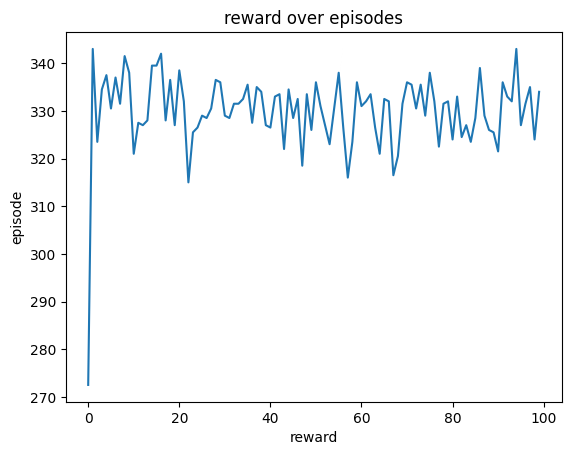

In [ ]:
from matplotlib import pyplot as plt

plt.plot(ep_rewards)
plt.title("reward over episodes")
plt.xlabel("reward")
plt.ylabel("episode")
plt.show()

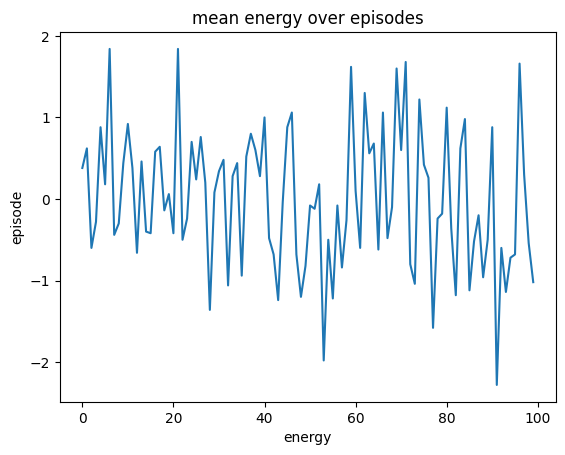

In [ ]:
plt.plot(ep_energies)
plt.title("mean energy over episodes")
plt.xlabel("energy")
plt.ylabel("episode")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import itertools

def generate_all_configs(N):
    """Generates all possible spin configurations for small N."""
    return list(itertools.product([-1, 1], repeat=N))

def compute_boltzmann_distribution(N, beta):
    """Computes exact Boltzmann distribution for small systems."""
    configs = generate_all_configs(N)
    energies = jnp.array([env.energy(jnp.array(s)) for s in configs])
    boltzmann_probs = jnp.exp(-beta * energies)
    Z = jnp.sum(boltzmann_probs)  # Partition function
    return {tuple(config): float(prob / Z) for config, prob in zip(configs, boltzmann_probs)}

def sample_agent_distribution(agent, env, num_samples=10000):
    """Samples configurations using the trained agent."""
    samples = []
    
    for _ in range(num_samples):
        state = env.reset()
        for _ in range(100):  # Steps per episode
            action = agent.select_action(state)
            state, _ = env.step(action)  # Update state
        samples.append(tuple(state))  # Store final equilibrium state
    
    # Count occurrences to estimate probability
    counts = Counter(samples)
    total = sum(counts.values())
    return {k: v / total for k, v in counts.items()}

def kl_divergence(P_agent, P_true):
    """Computes KL-divergence between the two distributions."""
    kl = 0.0
    for s in P_true.keys():
        if P_agent.get(s, 0) > 0:  # Avoid log(0)
            kl += P_agent[s] * jnp.log(P_agent[s] / P_true[s])
    return kl

# Compute distributions
#N = 6  # Use small N for exact computation
#T = 2.5
beta = 1.0 / T

env = ising_env(N, T)
agent_dist = sample_agent_distribution(agent, env, num_samples=1)
true_dist = compute_boltzmann_distribution(N, beta)

# Compute KL-divergence
kl_div = kl_divergence(agent_dist, true_dist)
print(f"KL-Divergence: {kl_div:.4f}")

# Plot distributions
fig, ax = plt.subplots(figsize=(10, 5))

# Convert to lists for plotting
configs = list(true_dist.keys())
true_probs = [true_dist[c] for c in configs]
agent_probs = [agent_dist.get(c, 0) for c in configs]

x_labels = ["".join(map(str, c)) for c in configs]  # Convert to string for x-axis

ax.bar(x_labels, true_probs, alpha=0.6, label="Boltzmann Distribution")
ax.bar(x_labels, agent_probs, alpha=0.6, label="Agent Distribution")
ax.set_xticklabels(x_labels, rotation=90)
ax.set_ylabel("Probability")
ax.set_title(f"Comparison of Sampling Distributions (N={N}, T={T})")
ax.legend()
plt.show()


TypeError: unhashable type: 'jaxlib.xla_extension.ArrayImpl'

: 

Text(0, 0.5, 'episode')

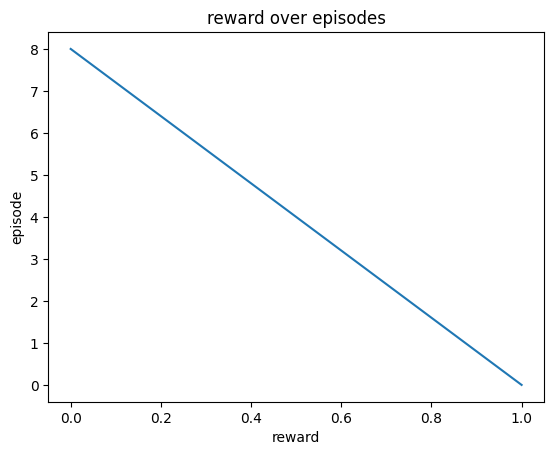

In [ ]:
from matplotlib import pyplot as plt
plt.plot(ep_rewards)
plt.title("reward over episodes")
plt.xlabel("reward")
plt.ylabel("episode")

In [ ]:
q_values = jnp.ones(shape=(64, 10))
actions = jnp.ones(shape=(64,))

In [358]:
import jax
import numpy as np
import jax.numpy as jnp
from flax import linen as nn
import optax
import matplotlib.pyplot as plt
from collections import deque
from functools import partial
from flax.training import train_state, checkpoints

class q_net(nn.Module): 
    num_actions: int

    def setup(self):
        self.dense1 = nn.Dense(128)
        self.dense2 = nn.Dense(128)
        self.output_layer = nn.Dense(self.num_actions)

    def __call__(self, x):
        x = nn.relu(self.dense1(x))
        x = nn.relu(self.dense2(x))
        return self.output_layer(x)

In [359]:
def energy_fn(state):
    return -jnp.sum(state * jnp.roll(state, shift=-1))

energy_fn_vmap = jax.vmap(energy_fn)

def reward_fn(state, next_state):
    return -energy_fn(next_state) # + energy_fn(state)

In [360]:
@partial(jax.jit, static_argnums=1)
def action_sampler_kernel(key, qnet, state, params, epsilon):
    key, rand_key, epsi_key = jax.random.split(key, 3)
    r = jax.random.uniform(epsi_key)
    epsilon_greedy = r < epsilon
    action = jnp.where(epsilon_greedy, 
                              jax.random.randint(rand_key, shape=(), minval=0, maxval=qnet.num_actions), 
                              jnp.argmax(qnet.apply(params, state)))
    next_state = state.at[action].multiply(-1)
    return key, (next_state, action)

@partial(jax.jit, static_argnums=(1, 2, 3))
def sampler(rng_key, qnet, n_samples, N, epsilon, params):
    def sample_step(carry, x):
        rng_key, (state, next_state, action, reward) = carry
        state = next_state
        rng_key, (next_state, action) = action_sampler_kernel(rng_key, qnet, state, params, epsilon)
        reward = reward_fn(state, next_state)
        return (rng_key, (state, next_state, action, reward)), (state, next_state, action, reward)
    
    rng_key, init_key, samples_key = jax.random.split(rng_key, 3)
    
    init_carry = (samples_key, 
                  (jax.random.choice(init_key, jnp.array([-1, 1]), shape = (N,)), 
                   jax.random.choice(init_key, jnp.array([-1, 1]), shape = (N,)), 
                   0, 
                   0))
    
    _, (states, next_states, actions, rewards) = jax.lax.scan(sample_step, init_carry, None, n_samples)
    return rng_key, states, next_states, actions, rewards

In [361]:
@partial(jax.jit, static_argnums=(1, 2, 3))
@partial(jax.vmap, in_axes=(None, None, None, None, None, None, 0), out_axes=0)
def sampler_vmap(key, qnet, n_samples, N, epsilon, params, init_state):
    def sample_step(carry, x):
        rng_key, (state, next_state, action, reward) = carry
        rng_key, (next_state, action) = action_sampler_kernel(rng_key, qnet, state, params, epsilon)
        reward = -reward_fn(state, next_state)
        return (rng_key, (state, next_state, action, reward)), (state, next_state, action, reward)
    
    new_key, samples_key = jax.random.split(key)
    init_carry = (samples_key, 
                  (init_state, 
                   init_state, 
                   0, 
                   0))
    _, (states, next_states, actions, rewards) = jax.lax.scan(sample_step, init_carry, None, n_samples)
    return new_key, states, next_states, actions, rewards

In [362]:
n_spins = 20
n_batch = 64
epsilon = 0.1
n_samples = 1_000

key = jax.random.PRNGKey(0)

init_samples = jax.random.choice(key, jnp.array([-1, 1]), shape = (n_batch, n_spins))

qnet = q_net(n_spins)
params = qnet.init(key, jnp.ones((n_spins,)))
%time
key, states, next_states, actions, rewards = sampler_vmap(key, qnet, n_samples, n_spins, epsilon, params, init_samples)

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 7.15 μs


In [363]:
actions.shape

(64, 1000)

In [364]:
key = jax.random.PRNGKey(0)
%time
key, states, next_states, actions, rewards = sampler(key, qnet, n_samples*n_batch, n_spins, epsilon, params)

CPU times: user 2 μs, sys: 2 μs, total: 4 μs
Wall time: 6.2 μs


In [365]:
print(next_states.shape)
print(actions.shape)

(64000, 20)
(64000,)


In [366]:
def loss_fn(params, qnet, states, actions, next_states, rewards):
    q_values = qnet.apply(params, states)
    q_values_next = qnet.apply(params, next_states)
    target_q_values = rewards + jnp.max(q_values_next, axis = -1)
    mask = jax.nn.one_hot(actions, qnet.num_actions)
    predicted_q_values = jnp.sum(q_values * mask, axis=-1)
    return jnp.mean((predicted_q_values - target_q_values)**2)

loss_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn), static_argnums=(1,))
loss_and_grad_fn_vmap = jax.jit(jax.vmap(loss_and_grad_fn, in_axes=(None, None, 0, 0, 0, 0)), static_argnums=(1,))

In [367]:
%time
value, grads = loss_and_grad_fn_vmap(params, qnet, states, actions, next_states, rewards)

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 4.05 μs


In [368]:
def add_to_buffer(buffer, states, actions, rewards, next_states):
    buffer.append((states, actions, rewards, next_states))
    return buffer

In [369]:
@partial(jax.jit, static_argnums=(1, 2, 3))
@partial(jax.vmap, in_axes=(None, None, None, None, None, None, None, 0), out_axes=0)
def sampler_with_buffer_vmap(key, qnet, n_samples, N, epsilon, params, buffer, init_state):
    def sample_step(carry, x):
        rng_key, (state, next_state, action, reward) = carry
        rng_key, (next_state, action) = action_sampler_kernel(rng_key, qnet, state, params, epsilon)
        new_buffer = add_to_buffer(buffer, state, action, reward, next_state)
        return (rng_key, (state, next_state, action, reward)), (state, next_state, action, reward)
    
    new_key, samples_key = jax.random.split(key)
    init_carry = (samples_key, 
                  (init_state, 
                   init_state, 
                   0, 
                   0))
    _, (states, next_states, actions, rewards) = jax.lax.scan(sample_step, init_carry, None, n_samples)
    return new_key, new_buffer

In [370]:
def buffer_replay(key, qnet, buffer, batch_size):
    batch = jax.random.choice(key, len(buffer), shape=(batch_size,), replace=False)
    batch = [buffer[i] for i in batch]
    states, actions, rewards, next_states = zip(*batch)
    return jnp.array(states), jnp.array(actions), jnp.array(rewards), jnp.array(next_states)

In [371]:
def update(params, grads, optimizer, opt_state):
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

In [398]:
n_spins = 10
n_batch = 64
final_epsilon = 0.1
init_epsilon = 1.0
decay_rate = 0.99
n_samples = 1_000
qnet = q_net(n_spins)
params = qnet.init(key, jnp.ones((n_spins,)))
n_episodes = 500
n_ter = 200
key = jax.random.PRNGKey(0)
opt = optax.adam(0.01)
opt_state = opt.init(params)
energies = []
losses = []
rewards_ = []
magnetizations = []

epsilon = init_epsilon

for episode in range(n_episodes):
    #epsilon = (init_epsilon - final_epsilon) * (1 - episode/n_episodes) + final_epsilon
    epsilon = jnp.where(epsilon > final_epsilon, epsilon * decay_rate, final_epsilon)
    key, states, next_states, actions, rewards = sampler(key, qnet, n_samples*n_batch, n_spins, epsilon, params)
    value, grads = loss_and_grad_fn(params, qnet, states, actions, next_states, rewards)
    params, opt_state = update(params, grads, opt, opt_state)
    losses.append(value)
    energies.append(jnp.mean(energy_fn_vmap(states)[-n_ter:]))
    rewards_.append(jnp.mean(rewards))
    magnetizations.append(jnp.mean(jnp.abs(jnp.mean(states[-n_ter:], axis=-1))))
    print(f"episode {episode}, loss: {value:.2f}, epsilon: {epsilon:.2f}, energy: {energies[-1]:.2f}, reward: {jnp.mean(rewards):.2f}, magnetization: {magnetizations[-1]:.2f}")

episode 0, loss: 11.60, epsilon: 0.99, energy: -0.30, reward: 0.04, magnetization: 0.23
episode 1, loss: 11.13, epsilon: 0.98, energy: 0.00, reward: 0.06, magnetization: 0.23
episode 2, loss: 11.13, epsilon: 0.97, energy: 0.12, reward: 0.04, magnetization: 0.27
episode 3, loss: 10.63, epsilon: 0.96, energy: 0.36, reward: 0.12, magnetization: 0.27
episode 4, loss: 10.05, epsilon: 0.95, energy: -0.28, reward: 0.12, magnetization: 0.28
episode 5, loss: 9.50, epsilon: 0.94, energy: -0.38, reward: 0.11, magnetization: 0.22
episode 6, loss: 8.96, epsilon: 0.93, energy: 0.22, reward: 0.06, magnetization: 0.30
episode 7, loss: 8.76, epsilon: 0.92, energy: -0.04, reward: 0.09, magnetization: 0.25
episode 8, loss: 8.71, epsilon: 0.91, energy: -0.56, reward: 0.13, magnetization: 0.26
episode 9, loss: 8.44, epsilon: 0.90, energy: 0.14, reward: 0.20, magnetization: 0.23
episode 10, loss: 8.45, epsilon: 0.90, energy: -0.24, reward: 0.24, magnetization: 0.25
episode 11, loss: 8.30, epsilon: 0.89, ene

In [219]:
print(states)

[[ 1 -1  1 -1 -1]
 [ 1 -1  1  1 -1]
 [ 1 -1  1  1  1]
 ...
 [ 1  1  1 -1 -1]
 [ 1  1 -1 -1 -1]
 [ 1  1 -1  1 -1]]


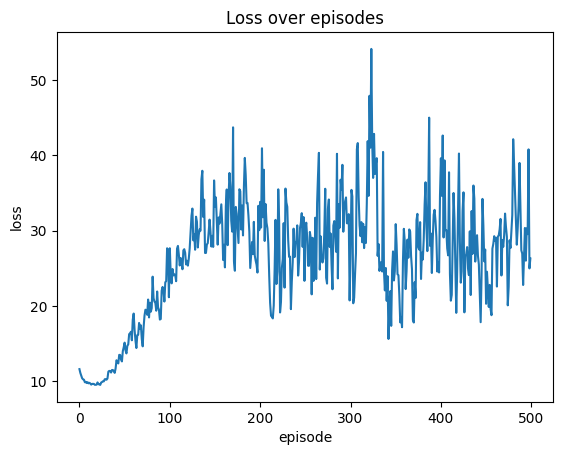

In [395]:
plt.plot(losses)
plt.title("Loss over episodes")
plt.xlabel("episode")
plt.ylabel("loss")
#plt.ylim(0, 3)
plt.show()

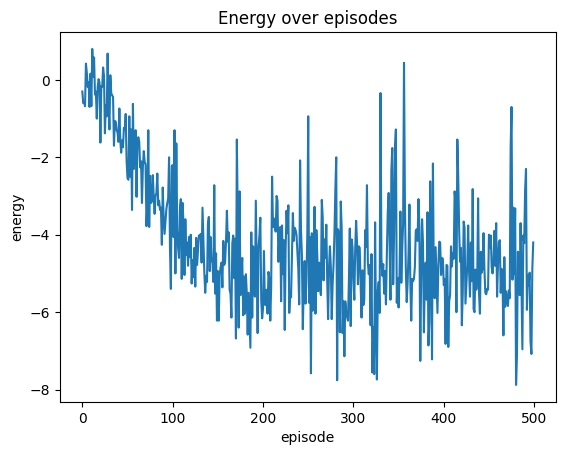

In [396]:
plt.plot(energies)
plt.title("Energy over episodes")
plt.xlabel("episode")
plt.ylabel("energy")
plt.show()

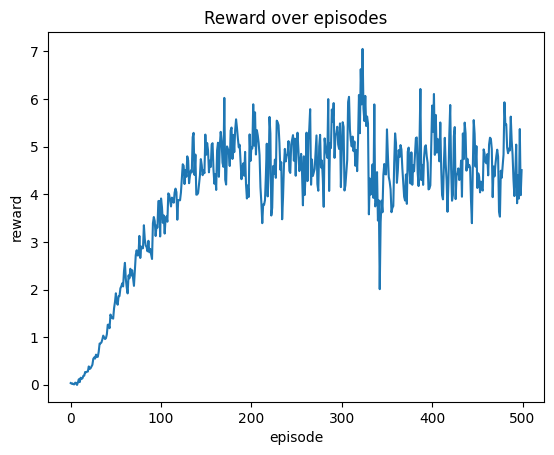

In [397]:
plt.plot(rewards_)
plt.title("Reward over episodes")
plt.xlabel("episode")
plt.ylabel("reward")
plt.show()

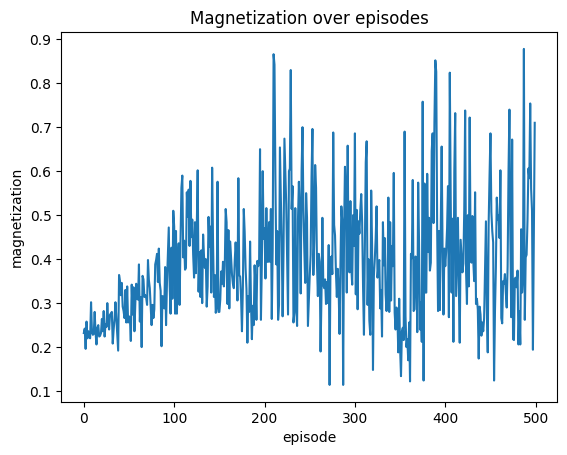

In [393]:
plt.plot(magnetizations)
plt.title("Magnetization over episodes")
plt.xlabel("episode")
plt.ylabel("magnetization")
plt.show()

In [348]:
import pickle
import flax.serialization
import jax
import numpy as np
import jax.numpy as jnp
from flax import linen as nn
import optax
import matplotlib.pyplot as plt
from collections import deque
from functools import partial
from flax.training import train_state, checkpoints

class q_net(nn.Module): 
    num_actions: int

    def setup(self):
        self.dense1 = nn.Dense(128)
        self.dense2 = nn.Dense(128)
        self.output_layer = nn.Dense(self.num_actions)

    def __call__(self, x):
        x = nn.relu(self.dense1(x))
        x = nn.relu(self.dense2(x))
        return self.output_layer(x)

def energy_fn(state, J, h):
    return -J * jnp.sum(state * jnp.roll(state, shift=-1)) - h * jnp.sum(state)

energy_fn_vmap = jax.vmap(energy_fn, in_axes=(0, None, None))

def reward_fn(state, next_state, J, h):
    return -energy_fn(next_state, J, h) # + energy_fn(state)

@partial(jax.jit, static_argnums=1)
def action_sampler_kernel(key, qnet, state, params, epsilon):
    key, rand_key, epsi_key = jax.random.split(key, 3)
    r = jax.random.uniform(epsi_key)
    epsilon_greedy = r < epsilon
    action = jnp.where(epsilon_greedy, 
                              jax.random.randint(rand_key, shape=(), minval=0, maxval=qnet.num_actions), 
                              jnp.argmax(qnet.apply(params, state)))
    next_state = state.at[action].multiply(-1)
    return key, (next_state, action)

@partial(jax.jit, static_argnums=(1, 2, 3))
def sampler(rng_key, qnet, n_samples, N, epsilon, params, J, h):
    def sample_step(carry, x):
        rng_key, (state, next_state, action, reward) = carry
        state = next_state
        rng_key, (next_state, action) = action_sampler_kernel(rng_key, qnet, state, params, epsilon)
        reward = reward_fn(state, next_state, J, h)
        return (rng_key, (state, next_state, action, reward)), (state, next_state, action, reward)
    
    rng_key, init_key, samples_key = jax.random.split(rng_key, 3)
    
    init_carry = (samples_key, 
                  (jax.random.choice(init_key, jnp.array([-1, 1]), shape = (N,)), 
                   jax.random.choice(init_key, jnp.array([-1, 1]), shape = (N,)), 
                   0, 
                   0))
    
    _, (states, next_states, actions, rewards) = jax.lax.scan(sample_step, init_carry, None, n_samples)
    return rng_key, states, next_states, actions, rewards 

def loss_fn(params, qnet, states, actions, next_states, rewards):
    q_values = qnet.apply(params, states)
    q_values_next = qnet.apply(params, next_states)
    target_q_values = rewards + jnp.max(q_values_next, axis = -1)
    mask = jax.nn.one_hot(actions, qnet.num_actions)
    predicted_q_values = jnp.sum(q_values * mask, axis=-1)
    return jnp.mean((predicted_q_values - target_q_values)**2)

loss_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn), static_argnums=(1,))
loss_and_grad_fn_vmap = jax.jit(jax.vmap(loss_and_grad_fn, in_axes=(None, None, 0, 0, 0, 0)), static_argnums=(1,))   

def save_params(params, filename="model_params.pkl", path="./saved_states/"):
    """Saves model parameters to a file."""
    filepath = path + filename
    with open(filepath, "wb") as f:
        pickle.dump(flax.serialization.to_bytes(params), f)

def load_params(path = "./saved_states/", filename="model_params.pkl"):
    """Loads model parameters from a pickle file."""
    filepath = path + filename
    with open(filepath, "rb") as f:
        return flax.serialization.from_bytes(None, pickle.load(f))

In [351]:
# physical system paramenters
n_spins = 10
J = 1.0
h_list = [-0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# RL paramenteres
final_epsilon = 0.1
init_epsilon = 1.0
decay_rate = 0.99

# training parameters
n_samples = 2_000
n_episodes = 500
n_ter = 200
n_print = 50

# qnet and optimizer
qnet = q_net(n_spins)
params = qnet.init(key, jnp.ones((n_spins,)))
opt = optax.adam(0.0001)
opt_state = opt.init(params)
key = jax.random.PRNGKey(0)

# trackers
energies = []
losses = []
rewards_ = []
magnetizations = []

for h in h_list:

    print(f"h: {h}")

    epsilon = init_epsilon

    for episode in range(n_episodes):
        epsilon = jnp.where(epsilon > final_epsilon, epsilon * decay_rate, final_epsilon)
        key, states, next_states, actions, rewards = sampler(key, qnet, n_samples*n_batch, n_spins, epsilon, params, J, h)
        value, grads = loss_and_grad_fn(params, qnet, states, actions, next_states, rewards)
        params, opt_state = update(params, grads, opt, opt_state)
        losses.append(value)
        energies.append(jnp.mean(energy_fn_vmap(states, J, h)[-n_ter:]))
        rewards_.append(jnp.mean(rewards))
        magnetizations.append(jnp.mean(jnp.mean(states[-n_ter:], axis=-1)))
        if episode%n_print==0:
            print(f"episode {episode}, h: {h}, energy: {energies[-1]:.2f}, reward: {jnp.mean(rewards):.2f}, m: {magnetizations[-1]:.2f}")
    
    save_params(params, filename=f"model_params_{h}.pkl")

h: -0.9
episode 0, h: -0.9, energy: 1.15, reward: -0.03, m: 0.15
episode 50, h: -0.9, energy: -2.44, reward: 2.03, m: -0.24
episode 100, h: -0.9, energy: -8.98, reward: 8.46, m: -0.58
episode 150, h: -0.9, energy: -13.35, reward: 14.38, m: -0.77
episode 200, h: -0.9, energy: -15.23, reward: 15.30, m: -0.87
episode 250, h: -0.9, energy: -15.27, reward: 15.53, m: -0.87
episode 300, h: -0.9, energy: -15.66, reward: 15.54, m: -0.88
episode 350, h: -0.9, energy: -15.39, reward: 15.54, m: -0.87
episode 400, h: -0.9, energy: -15.62, reward: 15.53, m: -0.88
episode 450, h: -0.9, energy: -15.19, reward: 15.53, m: -0.87
h: -0.8
episode 0, h: -0.8, energy: -0.38, reward: 0.12, m: 0.05
episode 50, h: -0.8, energy: -5.89, reward: 7.18, m: -0.40
episode 100, h: -0.8, energy: -12.64, reward: 10.63, m: -0.80
episode 150, h: -0.8, energy: -13.70, reward: 13.10, m: -0.83
episode 200, h: -0.8, energy: -14.27, reward: 14.25, m: -0.86
episode 250, h: -0.8, energy: -14.43, reward: 14.56, m: -0.87
episode 30

KeyboardInterrupt: 

In [344]:
final_epsilon

[0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.30000000000000004,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6000000000000001,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.8500000000000001,
 0.9,
 0.9500000000000001,
 1.0]

In [324]:
CKPT_DIR = '/Users/romanarmenta/Documents/Git-Projects/AlphaGOinJAX/Spin_Example/saved_states/ckpts'
checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=opt_state, step=0)
restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=opt_state)

assert jax.tree_util.tree_all(jax.tree_util.tree_map(lambda x, y: (x == y).all(), opt_state.params, restored_state.params))

AttributeError: 'tuple' object has no attribute 'params'

In [ ]:
import pickle
import flax.serialization

def save_params(params, filename="model_params.pkl", path="./saved_states/"):
    """Saves model parameters to a file."""
    filepath = path + filename
    with open(filepath, "wb") as f:
        pickle.dump(flax.serialization.to_bytes(params), f)

# Example usage:
save_params(params, "agent_params.pkl")

In [329]:
def load_params(path = "./saved_states/", filename="model_params.pkl"):
    """Loads model parameters from a pickle file."""
    filepath = path + filename
    with open(filepath, "rb") as f:
        return flax.serialization.from_bytes(None, pickle.load(f))

# Example usage:
loaded_params = load_params(filename = "agent_params.pkl")

In [334]:
assert jax.tree_util.tree_all(jax.tree_util.tree_map(lambda x, y: (x == y).all(), params, loaded_params))